In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from pysurvival.models.survival_forest import RandomSurvivalForestModel, ConditionalSurvivalForestModel, ExtraSurvivalTreesModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
from pysurvival.utils.display import compare_to_actual
from pysurvival.utils.display import create_risk_groups

/home/fbaldo/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
df = pd.read_excel('data.xlsx', engine='openpyxl')
list(df.columns)

['ctx',
 'codice_dm',
 'lista_id',
 'pers_sesso',
 'pers_eta_ingresso_in_lista',
 'diagnosi',
 'diagnosi_specifica',
 'eltr',
 'lista_ingresso_data',
 'tot_tx_organo',
 'tx_fegato_corrente',
 'iscriz_tx_comb',
 'tipo_combinato',
 'ric_HBsAg',
 'ric_DELTA',
 'ric_HCV',
 'ric_HCV_RNA',
 'ric_HIV',
 'ric_eccezione_MELD_PELD',
 'Na',
 'Peso',
 'Altezza',
 'BMI',
 'MELD_in_ingresso',
 'MELD_in_uscita',
 'chirurgia_addom',
 'chirurgia_addom_note',
 'trombosi_portale',
 'trombosi_portale_note',
 'TIPS',
 'ric_diabete',
 'HCC',
 'categoria_HCC',
 'HCC_esordio',
 'HCC_noduli',
 'HCC_downstaging',
 'HCC_diam_max',
 'HCC_diam_totale',
 'HCC_stadio_TNM',
 'HCC_resezione',
 'MELD_base',
 'MELD_na',
 'MELD_HCC',
 'AFP',
 'dialisi_ultimi_15gg',
 'lista_uscita_data',
 'causa_uscita',
 'data_decesso',
 'tx_effettivo_data',
 'scheda48h_tx_effettivo_combinato',
 'scheda48h_tipo_tx_effettivo_combinato',
 'fega_note',
 'UNOS',
 'data_UNOS',
 'CHILD',
 'ISO2_super_urgenza',
 'ISO2_tipo_super_urgenza',
 'ISO

In [23]:
df = df[['BMI', 'MELD_base', 'pers_sesso', 'ric_diabete', 'ric_HCV', 'data_trapianto', 'data_decesso', 'data_ultimo_agg_followup', 'pers_eta_ingresso_in_lista', 'HCC', 'trombosi_portale', 'ric_HBsAg']]
df['event'] = np.zeros(len(df))
categories = [ 'pers_sesso', 'ric_diabete', 'ric_HCV', 'HCC', 'trombosi_portale', 'ric_HBsAg']
df = pd.get_dummies(df, columns=categories, drop_first=True)
df.head(10)

BMI  MELD_base data_trapianto data_decesso data_ultimo_agg_followup  \
0  25.16        8.0     2004-10-22   2013-08-01                      NaT   
1  27.76       10.0            NaT          NaT                      NaT   
2  26.49       13.0            NaT          NaT                      NaT   
3  25.54       14.0            NaT   2004-01-28                      NaT   
4  21.47       16.0            NaT   2005-06-11                      NaT   
5  22.15       19.0     2004-12-01   2006-05-15                      NaT   
6  18.36       13.0            NaT   2004-08-25                      NaT   
7  27.94       21.0            NaT   2005-02-18                      NaT   
8  24.57       16.0            NaT          NaT                      NaT   
9    NaN       18.0     2004-03-22   2004-03-22                      NaT   

   pers_eta_ingresso_in_lista  event  pers_sesso_M  ric_diabete_SI  \
0                          54    0.0             1               0   
1                          64    0.0             1               0   
2                          56    0.0             1               1   
3                          51    0.0             1               1   
4                          43    0.0             1               0   
5                          63    0.0             0               0   
6                          55    0.0             0               0   
7                          63    0.0             1               0   
8                          62    0.0             1               1   
9                          43    0.0             1               0   

   ric_HCV_SI  HCC_SI  trombosi_portale_PARZIALE  trombosi_portale_SI  \
0           0       0                          0                    0   
1           1       1                          0                    0   
2           0       0                          0                    0   
3           0       0                          0                    0   
4           1       0                          0                    0   
5           1       1                          1                    0   
6           0       0                          0                    0   
7           1       0                          0                    0   
8           0       0                          0                    1   
9           0       0                          0                    0   

   ric_HBsAg_SI  
0             0  
1             0  
2             0  
3             0  
4             0  
5             0  
6             0  
7             0  
8             1  
9             0

In [24]:
for index, row in df.iterrows():
    if row['data_ultimo_agg_followup'] is pd.NaT and not row['data_decesso'] is pd.NaT:
        df.at[index,'data_ultimo_agg_followup'] = row['data_decesso']
        df.at[index, 'event'] = 1
    elif (row['data_decesso'] is pd.NaT and not row['data_ultimo_agg_followup'] is pd.NaT and row['data_ultimo_agg_followup'] < pd.Timestamp("2021-01-01") and row['data_ultimo_agg_followup'] > pd.Timestamp("2019-12-31")) :
        df.at[index,'data_decesso'] = row['data_ultimo_agg_followup']
        df.at[index, 'event'] = 0

In [25]:
df = df.dropna()
df['ToS'] = (df['data_decesso'] - df['data_trapianto']).dt.days
df = df.reset_index()
df = df.drop(['data_decesso', 'data_trapianto', 'data_ultimo_agg_followup', 'index'], axis=1)
df.shape

(420, 12)

In [26]:
df.head(40)

BMI  MELD_base  pers_eta_ingresso_in_lista  event  pers_sesso_M  \
0   25.16        8.0                          54    1.0             1   
1   22.15       19.0                          63    1.0             0   
2   23.23       21.0                          51    1.0             0   
3   24.00       11.0                          65    1.0             1   
4   30.47       30.0                          54    1.0             1   
5   22.27       26.0                          50    1.0             0   
6   32.81       27.0                          55    1.0             0   
7   19.27       22.0                          43    1.0             1   
8   27.34       27.0                          59    1.0             1   
9   19.62       10.0                          30    1.0             1   
10  24.61       20.0                          55    1.0             0   
11  21.76       15.0                          61    1.0             0   
12  27.55       12.0                          65    1.0             1   
13  27.44       15.0                          56    1.0             1   
14  26.22       18.0                          59    1.0             1   
15  28.20       22.0                          56    1.0             1   
16  23.78       17.0                          51    1.0             1   
17  18.44       28.0                          33    1.0             1   
18  18.52       27.0                          55    1.0             1   
19  24.00       26.0                          57    1.0             0   
20  23.34       14.0                          57    1.0             1   
21  24.49       12.0                          64    1.0             1   
22  18.36       34.0                          65    1.0             0   
23  20.20       16.0                          63    1.0             1   
24  24.39       16.0                          56    1.0             1   
25  29.41       28.0                          46    1.0             1   
26  29.05        8.0                          58    1.0             1   
27  29.94       17.0                          63    1.0             1   
28  21.26       23.0                          46    1.0             1   
29  25.14       16.0                          63    1.0             1   
30  24.22       26.0                          63    1.0             1   
31  29.07       42.0                          24    1.0             1   
32  26.99       14.0                          65    1.0             1   
33  21.11       19.0                          58    1.0             0   
34  19.07       30.0                          60    1.0             0   
35  22.60       28.0                          45    1.0             1   
36  24.91       22.0                          51    1.0             1   
37  23.31       14.0                          63    1.0             1   
38  23.24        6.0                          55    1.0             1   
39  26.73       10.0                          65    1.0             1   

    ric_diabete_SI  ric_HCV_SI  HCC_SI  trombosi_portale_PARZIALE  \
0                0           0       0                          0   
1                0           1       1                          1   
2                0           0       0                          0   
3                0           1       1                          0   
4                0           1       0                          0   
5                1           0       0                          0   
6                0           1       0                          0   
7                0           1       0                          0   
8                1           1       1                          0   
9                0           0       0                          0   
10               0           1       1                          1   
11               1           1       1                          0   
12               1           1       1                          0   
13               0           0       1        

In [27]:
index_train, index_test = train_test_split(range(len(df)), test_size = 0.3)

In [28]:
data_train = df.loc[index_train].reset_index( drop = True )
data_test  = df.loc[index_test].reset_index( drop = True )

features = ['pers_sesso_M', 'ric_diabete_SI', 'BMI', 'MELD_base', 'pers_eta_ingresso_in_lista', ]

# Creating the X, T and E inputs
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train['ToS'], data_test['ToS']
E_train, E_test = data_train['event'], data_test['event']

## Splitting Criterion

We aim at finding an optimal cutpoint to split data in two groups using maximally selected
rank statistics. A cutpoint is considered optimal if the separation of the survival curves in the two groups
is maximized.

If we consider $(X_i, Y_i)$ observation for $i \in \{1,..., n\}$, where $X_i$ represent the input features and $Y_i = (Z_i, \delta_i)$, with $Z_i$ indicating the survival time and $\delta_i$ a censoring indicator, we can use to define the optimal splitting using the log-rank of the attributes $a_1, ..., a_n$:

$a_i(Z, \delta) = \delta_i - \sum_{j = 1}^{\gamma_i(Z)} \frac{\delta_j}{(n - \gamma_j(Z) + 1)}$

$\gamma_j(Z) = \sum_{i=1}^n \textbf{1}_{\{Z_i \leq Z_j \}}$

So $\gamma_j$ counts the number of observations which have survival time lower than $Z_j$. 
The linear rank statistics for a cutpoint $\mu$ is computed as follows:

$S_{n\mu} = \sum_{i=1}^n \textbf{1}_{\{X_i \leq \mu \}} a_i(Z, \delta)$

## Random Survival Forest

In [53]:
# Fitting the model
csf = RandomSurvivalForestModel(num_trees=30)
csf.fit(X_train, T_train, E_train, max_features='sqrt', max_depth=5, min_node_size=30)
csf.variable_importance_table

feature  importance  pct_importance
0                   MELD_base    5.588952        0.466288
1                         BMI    2.640985        0.220338
2  pers_eta_ingresso_in_lista    2.187859        0.182534
3              ric_diabete_SI    1.017095        0.084857
4                pers_sesso_M    0.551163        0.045984

### C-index
Model’s ability to correctly provide a reliable ranking of the survival times based on the individual risk scores
In general, when the C-index is close to 1, the model has an almost perfect discriminatory power; but if it is close to 0.5, it has no ability to discriminate between low and high risk subjects.

In [54]:
c_index = concordance_index(csf, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(c_index))

C-index: 0.57


### Brier Score
Measures the average discrepancies between the status and the estimated probabilities at a given time

Thus, the lower the score (usually below 0.25), the better the predictive performance

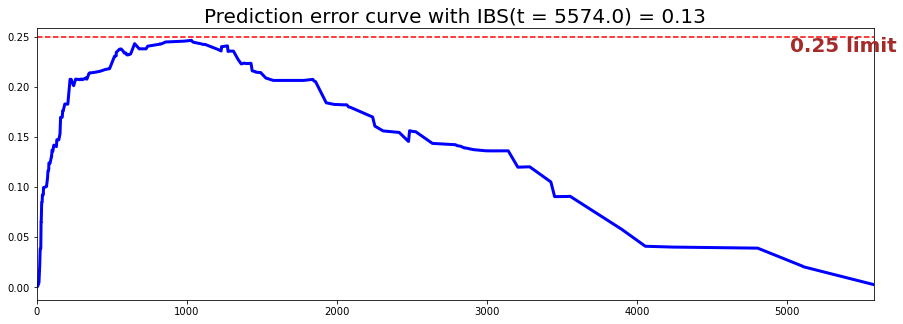

IBS: 0.13


In [55]:
ibs = integrated_brier_score(csf, X_test, T_test, E_test, t_max=6000,
    figure_size=(15,5))
print('IBS: {:.2f}'.format(ibs))

### Overall predictions

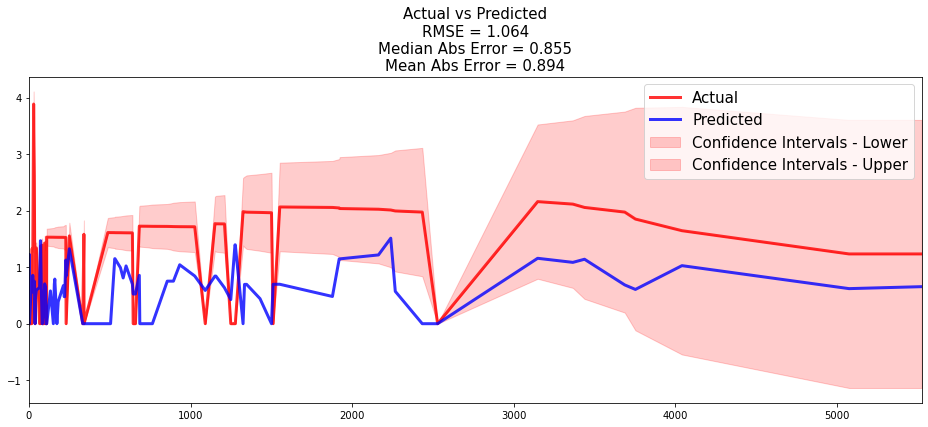

In [56]:
results = compare_to_actual(csf, X_test, T_test, E_test,
                            is_at_risk = False,  figure_size=(16, 6),
                            metrics = ['rmse', 'mean', 'median'])


## Extra Survival Trees

In [57]:
# Fitting the model
csf = ExtraSurvivalTreesModel(num_trees=30)
csf.fit(X_train, T_train, E_train, max_features='sqrt', max_depth=5, min_node_size=30)
csf.variable_importance_table.head(5)

feature  importance  pct_importance
0                pers_sesso_M    2.757683        0.406481
1                   MELD_base    2.207880        0.325440
2  pers_eta_ingresso_in_lista    1.254752        0.184950
3              ric_diabete_SI    0.563975        0.083130
4                         BMI   -0.429006        0.000000

In [58]:
c_index = concordance_index(csf, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(c_index))

C-index: 0.51


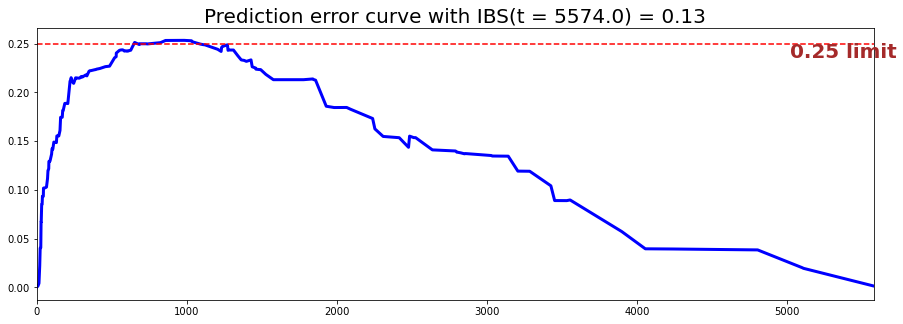

IBS: 0.13


In [59]:
ibs = integrated_brier_score(csf, X_test, T_test, E_test, t_max=6000,
    figure_size=(15,5))
print('IBS: {:.2f}'.format(ibs))

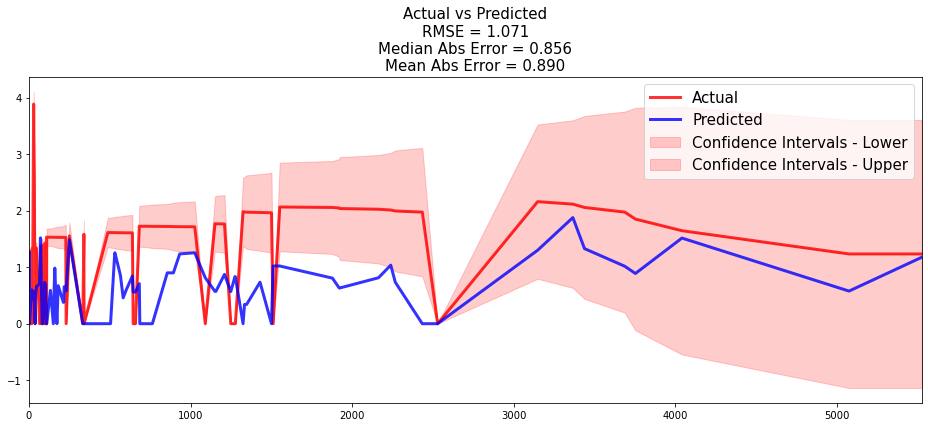

In [60]:
results = compare_to_actual(csf, X_test, T_test, E_test,
                            is_at_risk = False,  figure_size=(16, 6),
                            metrics = ['rmse', 'mean', 'median'])

## Conditional Survival Forest

In [61]:
# Fitting the model
csf = ConditionalSurvivalForestModel(num_trees=30)
csf.fit(X_train, T_train, E_train, max_features='sqrt', max_depth=5, min_node_size=30)
csf.variable_importance_table.head(5)

feature  importance  pct_importance
0                   MELD_base    4.152410        0.591666
1              ric_diabete_SI    1.434702        0.204427
2                pers_sesso_M    1.431057        0.203907
3                         BMI   -0.079035        0.000000
4  pers_eta_ingresso_in_lista   -0.893182        0.000000

In [62]:
c_index = concordance_index(csf, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(c_index))

C-index: 0.56


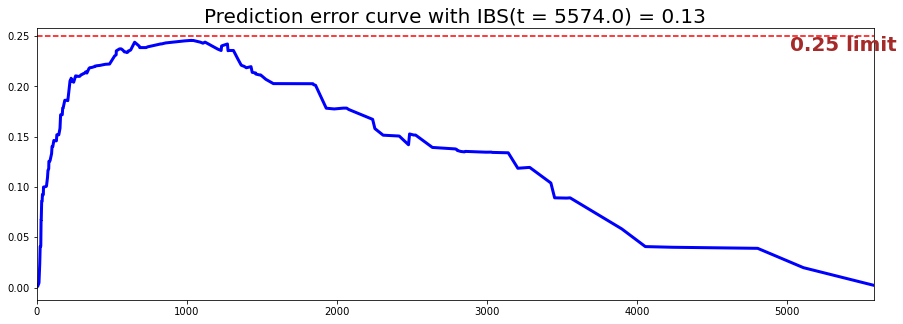

IBS: 0.13


In [63]:
ibs = integrated_brier_score(csf, X_test, T_test, E_test, t_max=6000,
    figure_size=(15,5))
print('IBS: {:.2f}'.format(ibs))

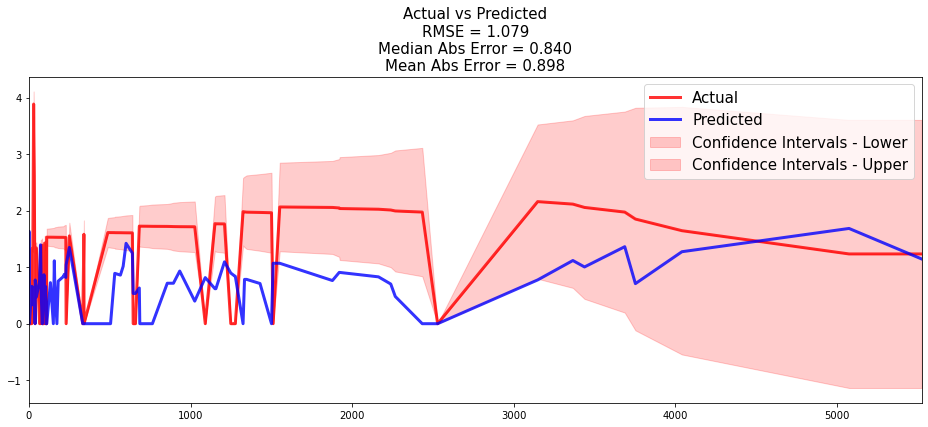

In [64]:
results = compare_to_actual(csf, X_test, T_test, E_test,
                            is_at_risk = False,  figure_size=(16, 6),
                            metrics = ['rmse', 'mean', 'median'])